In [63]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [64]:
%pip install librosa


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [65]:
import librosa

In [66]:
SAMPLE_RATE = 16000

In [67]:
marvin = os.path.join('marvin','0a7c2a8d_nohash_0.wav')

In [68]:
#resampling function
def resample_1d(wav, rate_in, rate_out):
    rate_in = tf.cast(rate_in, tf.float32)
    rate_out = tf.cast(rate_out, tf.float32)

    n_samples = tf.cast(tf.shape(wav)[0], tf.float32)
    n_out = tf.cast(tf.math.round(n_samples * rate_out / rate_in), tf.int32)

    # Original sample positions
    x_old = tf.linspace(0.0, n_samples - 1, tf.cast(n_samples, tf.int32))
    # New sample positions
    x_new = tf.linspace(0.0, n_samples - 1, n_out)

    wav = tf.expand_dims(wav, axis=0)
    wav = tf.expand_dims(wav, axis=-1)

    resampled = tf.image.resize(
        wav,
        size=[n_out, 1],
        method="bilinear"
    )

    return tf.squeeze(resampled)


In [69]:
#loading the wav file
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)

    wav, sample_rate = tf.audio.decode_wav(
        file_contents,
        desired_channels=1
    )

    wav = tf.squeeze(wav, axis=-1)  # (samples,)

    # 🔑 IMPORTANT: only resample if needed
    sample_rate = tf.cast(sample_rate, tf.int32)

    def resample():
        # put your resampling code here ONLY if sr != 16000
        return wav  # placeholder if you removed tfio

    wav = tf.cond(
        tf.not_equal(sample_rate, 16000),
        true_fn=resample,
        false_fn=lambda: wav
    )

    return wav

In [70]:
import soundfile as sf
audio_root = "audio"

output_dir = "noise"
chunk_size = 16000
target_sr = 16000

os.makedirs(output_dir, exist_ok=True)

clip_id = 0

# Automatically collect all .wav files
noise_clips = []

for root, dirs, files in os.walk(audio_root):
    for file in files:
        if file.endswith(".wav"):
            noise_clips.append(os.path.join(root, file))

# Now use your original loop
for path in noise_clips:

    # librosa → mono + resample to 16kHz
    audio, sr = librosa.load(path, sr=target_sr, mono=True)

    for i in range(0, len(audio), chunk_size):
        chunk = audio[i:i + chunk_size]

        if len(chunk) == chunk_size:
            sf.write(
                os.path.join(output_dir, f"noise_{clip_id}.wav"),
                chunk,
                target_sr
            )
            clip_id += 1

print(f"Created {clip_id} noise clips.")

Created 10338 noise clips.


Visulizing the Audio Data

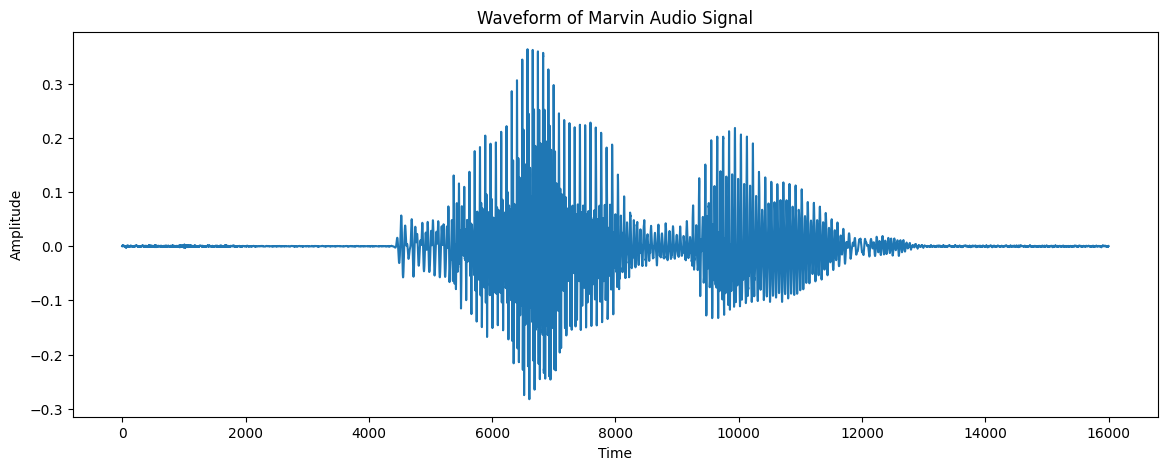

In [71]:
test_file = load_wav_16k_mono(marvin)
plt.figure(figsize=(14, 5))
plt.plot(test_file)
plt.title('Waveform of Marvin Audio Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [72]:
test_file

<tf.Tensor: shape=(16000,), dtype=float32, numpy=
array([-3.0517578e-05,  9.1552734e-05,  7.9345703e-04, ...,
        5.1879883e-04,  7.9345703e-04,  5.4931641e-04], dtype=float32)>

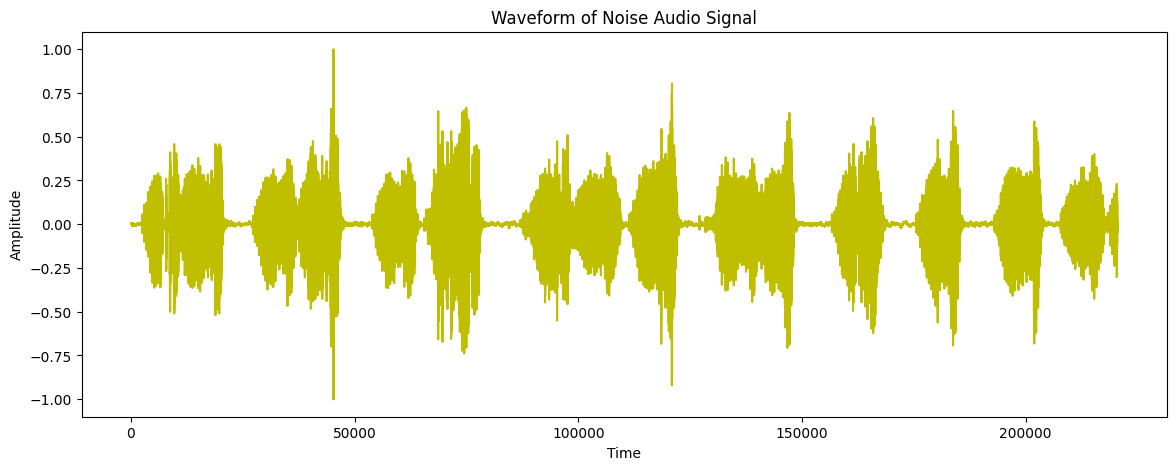

In [73]:
test_file_noise = load_wav_16k_mono(os.path.join('audio','2-52085-A-4.wav'))

plt.figure(figsize=(14, 5))
plt.plot(test_file_noise,'y')
plt.title('Waveform of Noise Audio Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [74]:
len(test_file_noise)

220500

In [75]:
#creating a positive and negative dataset using marvin and dishes noise
neg = tf.data.Dataset.list_files(os.path.join('noise') + '/*.wav')
pos = tf.data.Dataset.list_files(os.path.join('marvin') + '/*.wav')

positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))

In [76]:
positives.as_numpy_iterator().next()

(b'marvin/40b60ae9_nohash_0.wav', np.float32(1.0))

In [77]:

negatives.as_numpy_iterator().next()

(b'noise/noise_5895.wav', np.float32(0.0))

In [78]:
negatives = negatives.take(2500)
data = positives.concatenate(negatives)

In [79]:
data.as_numpy_iterator().next()

(b'marvin/ceaadb24_nohash_0.wav', np.float32(1.0))

In [80]:
FRAME_LENGTH = 640
HOP_LENGTH = 320

In [81]:
#extracting MFCC
def extract_mfcc(
    wav,
    sample_rate=SAMPLE_RATE,
    frame_length=FRAME_LENGTH,   # 40 ms
    frame_step=HOP_LENGTH,     # 20 ms
    num_mel_bins=40,
    num_mfcc=13,
    lower_freq=20.0,
    upper_freq=4000.0
):
    stft = tf.signal.stft(
        wav,
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=frame_length
    )

    spectrogram = tf.abs(stft)

    num_spectrogram_bins = spectrogram.shape[-1]

    mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins,
        num_spectrogram_bins,
        sample_rate,
        lower_freq,
        upper_freq
    )

    mel_spectrogram = tf.tensordot(
        spectrogram,
        mel_weight_matrix,
        1
    )

    mel_spectrogram.set_shape(
        spectrogram.shape[:-1].concatenate(
            mel_weight_matrix.shape[-1:]
        )
    )
    # 3️⃣ Log-Mel Spectrogram
    log_mel_spectrogram = tf.math.log(
        mel_spectrogram + 1e-6
    )
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
        log_mel_spectrogram
    )
    # Keep first num_mfcc coefficients
    mfccs = mfccs[:, :num_mfcc]

    return mfccs

In [82]:
mfcc_test = extract_mfcc(test_file)
mfcc_test_noise = extract_mfcc(test_file_noise)
mfcc_test.shape

TensorShape([49, 13])

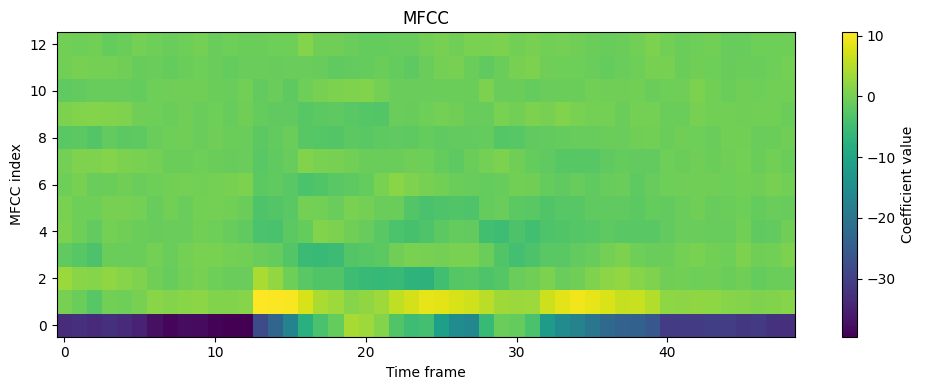

In [83]:
plt.figure(figsize=(10, 4))
plt.imshow(
    mfcc_test.numpy().T,   # transpose so MFCC index is on Y-axis
    aspect="auto",
    origin="lower"
)
plt.colorbar(label="Coefficient value")
plt.xlabel("Time frame")
plt.ylabel("MFCC index")
plt.title("MFCC")
plt.tight_layout()
plt.show()


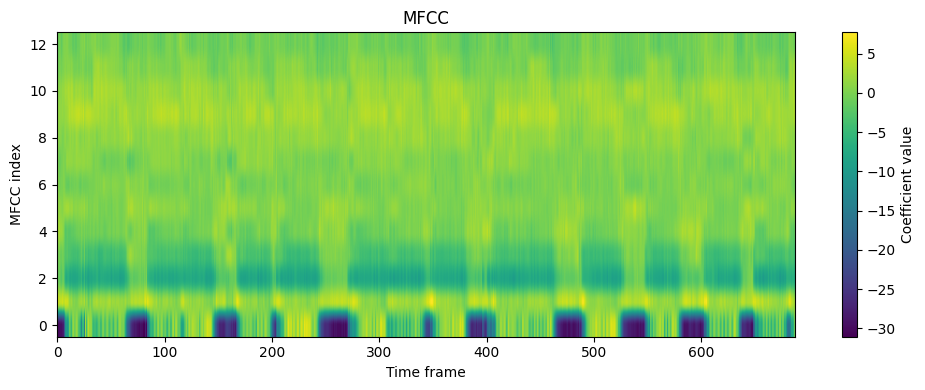

In [84]:
plt.figure(figsize=(10, 4))
plt.imshow(
    mfcc_test_noise.numpy().T,   # transpose so MFCC index is on Y-axis
    aspect="auto",
    origin="lower"
)
plt.colorbar(label="Coefficient value")
plt.xlabel("Time frame")
plt.ylabel("MFCC index")
plt.title("MFCC")
plt.tight_layout()
plt.show()

In [85]:
#preprocessing function
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)

    # Trim to 1 second
    wav = wav[:16000]

    # Pad if shorter
    pad_len = tf.maximum(0, 16000 - tf.shape(wav)[0])
    wav = tf.pad(wav, paddings=[[pad_len, 0]])

    # MFCC extraction → (time_frames, num_mfcc)
    mfcc = extract_mfcc(wav)

    return mfcc, label


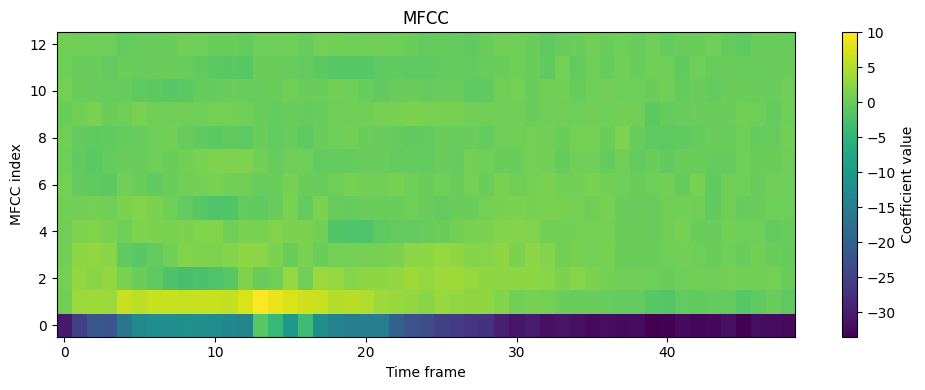

In [86]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
mfcc , label = preprocess(filepath, label)
plt.figure(figsize=(10, 4))
plt.imshow(
    mfcc.numpy().T,  # transpose so MFCC index is on Y-axis
    aspect="auto",
    origin="lower"
)
plt.colorbar(label="Coefficient value")
plt.xlabel("Time frame")
plt.ylabel("MFCC index")
plt.title("MFCC")
plt.tight_layout()
plt.show()

In [87]:
data = (
    data
    .shuffle(5000)
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
)


In [88]:
#creating a training and validation set
train = data.take(2100)
validation = data.skip(2100).take(900)



In [89]:
samples, labels = next(iter(train))
labels


<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [90]:
#Mean of training set
sum_ = tf.zeros((13,), dtype=tf.float32)
count = 0

for x, y in train:              # x: [B, T, 13]
    sum_ += tf.reduce_sum(x, axis=[0, 1])   # reduce batch + time
    count += tf.shape(x)[0] * tf.shape(x)[1]

mean = sum_ / tf.cast(count, tf.float32)
mean.shape   # (13,)



2026-02-12 20:53:38.175485: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


TensorShape([13])

In [91]:
sum_sq = tf.zeros((13,), dtype=tf.float32)
count_sq = 0

for x, y in train:              # x: [B, T, 13]
    sum_sq += tf.reduce_sum(tf.square(x), axis=[0, 1])
    count_sq += tf.shape(x)[0] * tf.shape(x)[1]

second_moment = sum_sq / tf.cast(count_sq, tf.float32)
second_moment.shape   # (13,)


TensorShape([13])

In [92]:
#standard deviation of training set
std = tf.sqrt(second_moment - mean**2)
std.shape   # (13,)


TensorShape([13])

In [93]:
#Normalization function
EPS = 1e-6

def normalize(x_d, y_d):
    # x_d: [T, 13] or [B, T, 13]
    x_d = (x_d - mean) / (std + EPS)
    return x_d, y_d


In [94]:
train = (
    train
    .map(normalize)
    .batch(32)
    .cache()# ← SINGLE batch here
    .prefetch(tf.data.AUTOTUNE)
)

validation = (
    validation
    .map(normalize)
    .batch(32)
    .cache()
    .prefetch(tf.data.AUTOTUNE))


In [95]:
for x, y in train.take(1):
    print(tf.reduce_mean(x, axis=[0, 1]))     # ≈ 0
    print(tf.math.reduce_std(x, axis=[0, 1])) # ≈ 1


tf.Tensor(
[-1.1348308   0.24744295  0.12138163  0.12498281  0.12370853  0.13578175
  0.14653671  0.13589099  0.12412361  0.12058572  0.12113434  0.11267579
  0.12095909], shape=(13,), dtype=float32)
tf.Tensor(
[2.6285832  0.3532825  0.22975111 0.14494368 0.12471825 0.12176641
 0.10305306 0.09706204 0.08359544 0.0725632  0.07142576 0.06894303
 0.05993009], shape=(13,), dtype=float32)


2026-02-12 20:53:38.957923: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [96]:
sample = next(iter(train))
print(sample[0].shape)


(32, 49, 13)


2026-02-12 20:53:39.026152: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [97]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(49, 13, 1)),

    tf.keras.layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.DepthwiseConv2D((3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Conv2D(64, (1, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])



In [98]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-4,
    clipnorm=1.0
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.Precision(name="precision",thresholds = 0.4),
        tf.keras.metrics.Recall(name="recall",thresholds=0.4)
    ]
)


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6638 - precision: 0.4660 - recall: 0.9075 - val_loss: 0.6878 - val_precision: 0.4000 - val_recall: 1.0000
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6397 - precision: 0.5123 - recall: 0.8863 - val_loss: 0.6809 - val_precision: 0.4000 - val_recall: 1.0000
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6180 - precision: 0.5377 - recall: 0.8635 - val_loss: 0.6683 - val_precision: 0.4000 - val_recall: 1.0000
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5966 - precision: 0.5615 - recall: 0.8719 - val_loss: 0.6500 - val_precision: 0.4364 - val_recall: 1.0000
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5767 - precision: 0.5763 - recall: 0.8649 - val_loss: 0.6274 - val_precision: 0.4964 - val_recall: 0.9667
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5587 - precision: 0.5937 - recall: 0.8627 - val_loss: 0.6031 - val_precision: 0.5569 - val_recall: 0.8972
Ep

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 49, 13, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 49, 13, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 49, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 49, 13, 32)     │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 49, 13, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 49, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 49, 13, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 49, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 49, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,477 (37.02 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 6,148 (24.02 KB)

None


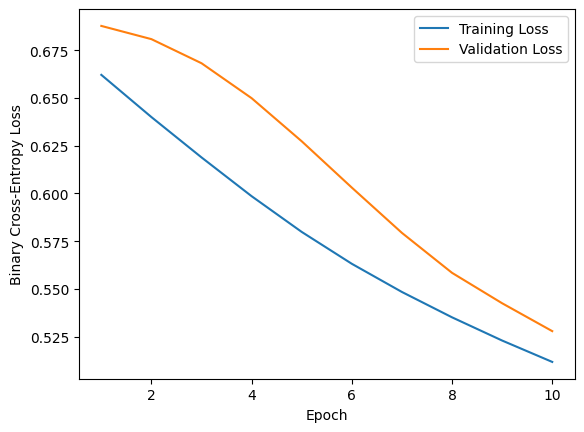

In [99]:
steps_per_epoch = 448 // 32
validation_steps = 192 // 32

history_cnn = model.fit(
    train,
    validation_data=validation,
    epochs=10,
)

print(model.summary())

epochs = range(1, len(history_cnn.history['loss']) + 1)

plt.figure()
plt.plot(epochs, history_cnn.history['loss'], label='Training Loss')
plt.plot(epochs, history_cnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.legend()
plt.show()




In [100]:
loss, precision, recall = model.evaluate(validation)
print(f"Validation precision: {precision:.3f}, recall: {recall:.3f}")



29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5287 - precision: 0.6095 - recall: 0.8842
Validation precision: 0.596, recall: 0.897


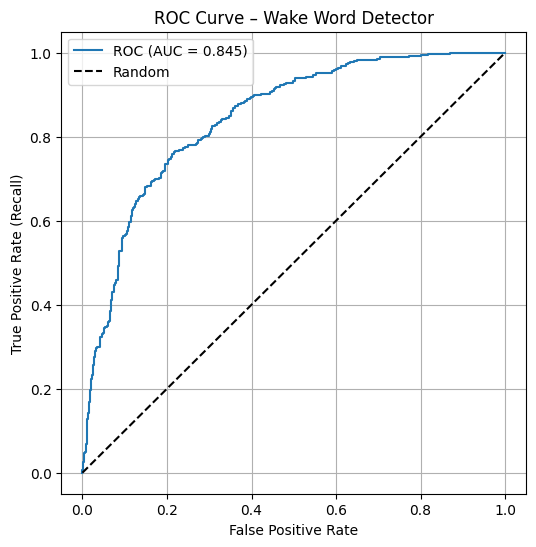

In [101]:
from sklearn.metrics import roc_curve, auc


y_true = []
y_score = []  # probabilities

for x, y in validation:
    probs = model.predict(x, verbose=0)
    y_true.extend(y.numpy())
    y_score.extend(probs.squeeze())

y_true = np.array(y_true)
y_score = np.array(y_score)



fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve – Wake Word Detector")
plt.legend()
plt.grid(True)
plt.show()


In [102]:
test = data.skip(3000).take(20).batch(16)
loss, precision, recall = model.evaluate(test)
print(f"Validation precision: {precision:.3f}, recall: {recall:.3f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.7462 - precision: 0.6326 - recall: 0.6094 
Validation precision: 0.636, recall: 0.636


In [103]:
pos = 0
neg = 0

for x, y in test.unbatch():
    if y == 1:
        pos += 1
    else:
        neg += 1

print("Positives:", pos)
print("Negatives:", neg)


Positives: 11
Negatives: 9


In [104]:
y_probs = model.predict(test)

print("Min prob:", y_probs.min())
print("Max prob:", y_probs.max())
print("Mean prob:", y_probs.mean())


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step 
Min prob: 1.5987077e-06
Max prob: 0.9687152
Mean prob: 0.3538987


In [105]:
pos = 0
neg = 0

for x, y in train.unbatch():
    if y == 1:
        pos += 1
    else:
        neg += 1

print("Train Positives:", pos)
print("Train Negatives:", neg)


Train Positives: 876
Train Negatives: 1224


In [106]:
pos = 0
neg = 0

for x, y in validation.unbatch():
    if y == 1:
        pos += 1
    else:
        neg += 1

print("validation Positives:", pos)
print("validation Negatives:", neg)


validation Positives: 360
validation Negatives: 540


In [107]:
unique = set()

for x, y in train.unbatch():
    unique.add(int(y.numpy()))

print(unique)



{0, 1}


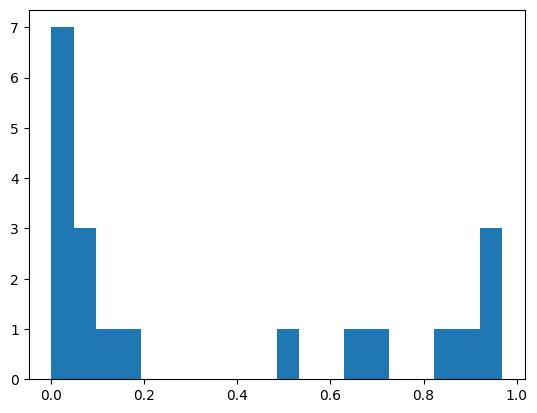

In [108]:
plt.hist(y_probs, bins=20)
plt.show()

In [109]:
data = positives.concatenate(negatives)

dataset_size = sum(1 for _ in data)
print("Total dataset size:", dataset_size)


Total dataset size: 4246


In [110]:
y_true = []
for x, y in validation:
    y_true.extend(y.numpy())

y_true = np.array(y_true)

# 2️⃣ Get model predictions
y_pred = model.predict(validation)
y_pred = y_pred.ravel()  # flatten to 1D

# 3️⃣ Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# 4️⃣ Compute Youden's J statistic
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_threshold = thresholds[best_idx]

print("Best Threshold:", best_threshold)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Best Threshold: 0.47432482
